# ガウス過程回帰

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 訓練データ生成

In [2]:
x = np.linspace(0, .7, 7)
y = np.sin(2 * np.pi * x) + np.random.normal(scale=0.25, size=x.shape)
x_train = x
y_train = y

In [3]:
# 真値
xx = np.linspace(0, 1, 100)
y_true = np.sin(2 * np.pi * xx)

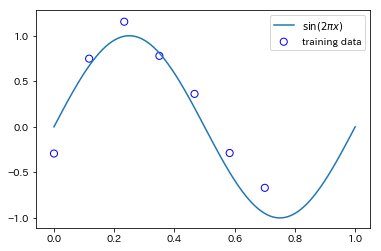

In [4]:
plt.scatter(x_train, y_train,facecolor="none", edgecolor="b", s=50,  label="training data")
plt.plot(xx, y_true, label="$\sin(2\pi x)$")
plt.legend()

## 学習

線形回帰モデル$y(x) = \boldsymbol{w}^{\mathrm{T}} \boldsymbol{\phi(x)}$において、重み係数$\boldsymbol{w}$の分布が中心$\boldsymbol{0}$のガウス分布に従うとき、$y$も1次元ガウス分布に従い、$\boldsymbol{y} = \Phi \boldsymbol{w}$は多次元ガウス分布に従う。

$\mathbb{E}[\boldsymbol{y}] = \boldsymbol{0}$, $\mathbb{E}[\boldsymbol{y} \boldsymbol{y}^{\mathrm{T}}] = K$

より、$\boldsymbol{y}$の同時分布は$p(\boldsymbol{y}) = \mathcal{N}(\boldsymbol{y} | \boldsymbol{0}, K)$となる。ただし、$K$はグラム行列であり、各要素はカーネル関数の値である($K_{ij} = k(x_{i}, x_{j})$)。

観測値$\boldsymbol{t} = [t_{1}, t_{2}, ..., t_{N}]^{\mathrm{T}}$にはノイズが加わると仮定すると、$p(\boldsymbol{t} | \boldsymbol{y}) = \mathcal{N}(\boldsymbol{t} | \boldsymbol{y}, \beta^{-1} I_{N})$と書ける。ただし、$\beta$は精度パラメータである。

周辺化により$\boldsymbol{t}$の同時分布は以下のように求まる。

$p(\boldsymbol{t}) = \int p(\boldsymbol{t} | \boldsymbol{y}) p(\boldsymbol{y}) d \boldsymbol{y} = \mathcal{N}(\boldsymbol{t} | \boldsymbol{0}, C_{N})$

ただし、$C_{N} = \beta^{-1} I_{N} + K$である。

共分散行列$C_{N}$がパラメータ$\boldsymbol{\theta}$に依存するとき、対数尤度関数は、

$\ln p(\boldsymbol{t} | \boldsymbol{\theta}) = -\frac{1}{2} \ln{|C_{N}|} - \frac{1}{2} \boldsymbol{t}^{\mathrm{T}} C_{N}^{-1} \boldsymbol{t} - \frac{N}{2} \ln{2 \pi}$

となり、パラメータ$\theta_{i}$による偏微分は、以下のように表される。

$\frac{\partial}{\partial \theta_{i}} \ln{p(\boldsymbol{t} | \boldsymbol{\theta})} = -\frac{1}{2} \text{Tr}(C_{N}^{-1} \frac{\partial C_{N}}{\partial  \theta_{i}}) + \frac{1}{2} \boldsymbol{t}^{\mathrm{T}} C_{N}^{-1} \frac{\partial C_{N}}{\partial \theta_{i}} C_{N}^{-1} \boldsymbol{t}$

カーネル関数を$k(x, x') = a \exp{-b (x - x')^{2}}$とする

以下では、カーネル関数を$k(x, x') = a \exp{(-b (x - x')^{2})}$とし、

$\frac{\partial k}{\partial a} = \exp{(-b (x - x')^{2})}$

$\frac{\partial k}{\partial b} = -a (x - x')^{2}\exp{(-b (x - x')^{2})}$

であることを利用して、最急降下法でパラメータ$a, b$を最適化する。

In [5]:
def rbf_kernel(x, X, a, b):
    return a * np.exp(-b * (x - X)**2)

def build_kernel_matrix(X1, X2, a, b):
    K = np.zeros((len(X1), len(X2)))
    for i in range(len(X1)):
        K[i] = rbf_kernel(X1[i], X2, a, b)
    return K

def gram_derivatives(X, Gram, a, b):
    derivative_a = Gram / a    
    derivative_b = -Gram
    for i in range(len(X)):
        derivative_b[i] =  derivative_b[i] * (X[i] - X)**2
    return derivative_a, derivative_b

In [6]:
X = x_train
t = y_train

# 初期値
a = 1.
b = 1.
beta = 100

iter_max = 1000
learning_rate = 0.01

I = np.eye(len(X))
for i in range(iter_max):
    Gram = build_kernel_matrix(X, X, a, b)
    CN = I / beta + Gram
    CN_inv = np.linalg.inv(CN)

    gradients = gram_derivatives(X, Gram, a, b)
    update_a, update_b = [-0.5 * np.trace(CN_inv.dot(grad)) + 0.5 * t.dot(CN_inv.dot(grad).dot(CN_inv).dot(t)) for grad in gradients]
    a += learning_rate * update_a
    b += learning_rate * update_b
    
    if np.allclose(np.abs(update_a) + np.abs(update_b), 0):
        break

## 予測

$p(\boldsymbol{t}_{N+1}) = \mathcal{N}(\boldsymbol{t}_{N+1} | \boldsymbol{0}, C_{N})$であり、

\begin{eqnarray}
C_{N+1} = \left( 
\begin{array}{cc}
C_{N}, \boldsymbol{k}\\
\boldsymbol{k}^{\mathrm{T}}, c
\end{array}
\right)
\end{eqnarray}

ただし、$\boldsymbol{k}$は要素$k(x_{n}, x_{N+1}) (n = 1, 2, ..., N)$を持つベクトルであり、$c=k(x_{N+1}, x_{N+1}) + \beta^{-1}$とする。

ここから条件付き分布$p(t_{N+1} | \boldsymbol{t}_{N})$は平均$m(x_{N+1}) = \boldsymbol{k}^{\mathrm{T}} C_{N}^{-1} \boldsymbol{t}$と分散$\sigma^{2}(x_{N+1}) = c - \boldsymbol{k}^{\mathrm{T}} C_{N}^{-1} \boldsymbol{k}$を持つようなガウス分布になる。

In [7]:
K = build_kernel_matrix(xx,  X, a, b)
mean = np.dot(K, CN_inv.dot(t))
c = 1 / beta + a
var = c - np.sum(np.dot(K, CN_inv) * K, axis=1)

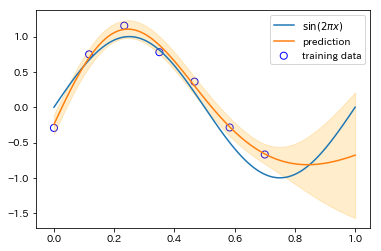

In [8]:
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(xx, y_true, label="$\sin(2\pi x)$")
plt.plot(xx, mean, label="prediction")
plt.fill_between(xx, mean-np.sqrt(var), mean+np.sqrt(var), alpha=0.2, color='orange')
plt.legend()
plt.show()